<div style="display: none">
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D

######################################## Data preparation #########################################

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

X = df[['Por', 'Brittle']].values.reshape(-1,2)
Y = df['Prod']

######################## Prepare model data point for visualization ###############################

x = X[:, 0]
y = X[:, 1]
z = Y

x_pred = np.linspace(6, 24, 30)   # range of porosity values
y_pred = np.linspace(0, 100, 30)  # range of brittleness values
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

################################################ Train #############################################

ols = linear_model.LinearRegression()
model = ols.fit(X, Y)
predicted = model.predict(model_viz)

############################################## Evaluate ############################################

r2 = model.score(X, Y)

############################################## Plot ################################################

plt.style.use('default')

fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

axes = [ax1, ax2]

for ax in axes:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('Porosity (%)', fontsize=12)
    ax.set_ylabel('Brittleness', fontsize=12)
    ax.set_zlabel('Gas Prod. (Mcf/day)', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)

fig.suptitle('3D multiple linear regression model', fontsize=20)

fig.tight_layout()
</div>

There are many advanced machine learning methods with robust prediction accuracy. While complex models may outperform simple models in predicting a response variable, simple models are better for understanding the impact & importance of each feature on a response variable. When the task at hand can be described by a linear model, linear regression triumphs over all other machine learning methods in feature interpretation due to its simplicity. 

This post attempts to help your understanding of linear regression in multi-dimensional feature space, model accuracy assessment, and provide code snippets for multiple linear regression in Python.

<div id="toc_container">
    <p class="toc_title">Contents</p>
    <ul class="toc_list">
        <li><a href="#Sample data description"><span class="toc_label">0</span>Sample data description</a></li>
        <li><a href="#Multiple linear regression"><span class="toc_label">1</span>Multiple linear regression</a></li>
        <ul>
            <li><a href="#Data encoding - regression with categorical variables"><span class="toc_label">Notes:</span>Data encoding - regression with categorical variables</a></li>
            <li><a href="#2D linear regression with scikit-learn"><span class="toc_label">Pythonic Tip:</span>2D regression with scikit-learn</a></li>
            <li><a href="#Forcing zero y-intercept"><span class="toc_label">Pythonic Tip:</span>Forcing zero y-intercept</a></li>
            <li><a href="#3D+ linear regression with scikit-learn"><span class="toc_label">Pythonic Tip:</span>3D+ regression with scikit-learn</a></li>
        </ul>
        <li><a href="#Introduction to multicollinearity"><span class="toc_label">2</span>Introduction to multicollinearity</a></li>
    </ul>
</div>

<div id="Sample data description"></div>

## 0. Sample data description

We will use one sample data throughout this post. The sample data is relevant to the oil & gas industry. It is originally from <a href="https://github.com/GeostatsGuy" target="_blank">Dr. Michael Pyrcz</a>, petroleum engineering professor at the University of Texas at Austin. The original data can be found from his <a href="https://github.com/GeostatsGuy/GeoDataSets/blob/master/unconv_MV_v5.csv" target="_blank">github repo</a>. You can also use <a href="https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv" target="_blank">direct download</a>, or directly access it using pandas url like below:

In [1]:
import pandas as pd

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

In [2]:
df.head(10)

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832
5,6,14.53,4.81,2.69,53.60,0.94,1.67,4395.763259
6,7,13.49,3.60,2.93,63.71,0.80,1.85,4104.400989
7,8,11.58,3.03,3.25,53.00,0.69,1.93,3496.742701
8,9,12.52,2.72,2.43,65.77,0.95,1.98,4025.851153
9,10,13.25,3.94,3.71,66.20,1.14,2.65,4285.026122


<div><hr></div>

**Description of headers**

0. *Well* : well index
1. *Por* : well average porosity (%) 
2. *Perm* : permeability (mD)
3. *AI* : accoustic impedance (kg/m2s*10^6)
4. *Brittle* : brittleness ratio (%) 
5. *TOC* : total organic carbon (%) 
6. *VR* : vitrinite reflectance (%)
8. *Prod* : gas production per day (MCFD) - **Response Variable**

<div><hr></div>

We have six features (*Por, Perm, AI, Brittle, TOC, VR*) to predict the response variable (*Prod*). Based on the permutation feature importances shown in <a href="#fig-1">figure (1)</a>, *Por* is the most important feature, and *Brittle* is the second most important feature. 

Permutation feature ranking is out of the scope of this post, and will not be discussed in detail. Feature importances are obtained with <a href="https://github.com/parrt/random-forest-importances" target="_blank">rfpimp</a> python library. For more information about permutation feature ranking, refer to this article: <a href="https://explained.ai/rf-importance/" target="_blank">Beware Default Random Forest Importances</a>

<div id="fig-1" class="row full_screen_margin_md mobile_responsive_plot_full_width" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multiple_linear_permutation_feature_importance.png"></div>
    <div class="col-12"><p class="image-description">Figure 1: Permutation feature ranking</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (1)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import rfpimp
                import pandas as pd
                import numpy as np
                from sklearn.ensemble import RandomForestRegressor
                from sklearn.model_selection import train_test_split

                ######################################## Data preparation #########################################

                file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
                df = pd.read_csv(file)
                features = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod']

                ######################################## Train/test split #########################################

                df_train, df_test = train_test_split(df, test_size=0.20)
                df_train = df_train[features]
                df_test = df_test[features]

                X_train, y_train = df_train.drop('Prod',axis=1), df_train['Prod']
                X_test, y_test = df_test.drop('Prod',axis=1), df_test['Prod']

                ################################################ Train #############################################

                rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
                rf.fit(X_train, y_train)

                ############################### Permutation feature importance #####################################

                imp = rfpimp.importances(rf, X_test, y_test)

                ############################################## Plot ################################################

                fig, ax = plt.subplots(figsize=(6, 3))

                ax.barh(imp.index, imp['Importance'], height=0.8, facecolor='grey', alpha=0.8, edgecolor='k')
                ax.set_xlabel('Importance score')
                ax.set_title('Permutation feature importance')
                ax.text(0.8, 0.15, 'aegis4048.github.io', fontsize=12, ha='center', va='center',
                        transform=ax.transAxes, color='grey', alpha=0.5)
                plt.gca().invert_yaxis()

                fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

<div id="Multiple linear regression"></div>

## 1. Multiple linear regression

Multiple linear regression model has the following structure:

<div id="eq-1" style="font-size: 1rem;">
$$ y = \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n + \beta_0\tag{1}$$
</div>

<div class="eq-terms">
    <div class="row eq-terms-where">where</div>
    <div class="row">
        <div class="col-3">$y$</div>
        <div class="col-9">: response variable</div>
    </div>
    <div class="row">
        <div class="col-3">$n$</div>
        <div class="col-9">: number of features</div>
    </div>
    <div class="row">
        <div class="col-3">$x_n$</div>
        <div class="col-9">: <span style="font-size: 0.85rem;">$n$</span>-th feature</div>
    </div>    
    <div class="row">
        <div class="col-3">$\beta_n$</div>
        <div class="col-9">: regression coefficient (weight) of the <span style="font-size: 0.85rem;">$n$</span>-th feature</div>
    </div>
    <div class="row">
        <div class="col-3">$\beta_0$</div>
        <div class="col-9">: <span style="font-size: 0.85rem;">y</span>-intercept</div>
    </div>    
</div>

Bivarate linear regression model (that can be visualized in 2D space) is a simplification of <a href="#eq-1">eq (1)</a>. Bivariate model has the following structure:

<div id="eq-2" style="font-size: 1rem;">
$$ y = \beta_1 x_1 + \beta_0 \tag{2}$$
</div>

A picture is worth a thousand words. Let's try to understand the properties of multiple linear regression models with visualizations. First, 2D bivariate linear regression model is visualized in <a href='#fig-2'>figure (2)</a>, using *Por* as a single feature. Although porosity is the most important feature regarding gas production, porosity alone captured only 74% of variance of the data. 

<div id="fig-2" class="row full_screen_margin_md mobile_responsive_plot_full_width" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multiple_linear_bivariate_regression.png"></div>
    <div class="col-12"><p class="image-description">Figure 2: 2D Linear regression model</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (2)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import pandas as pd
                import matplotlib.pyplot as plt
                from sklearn import linear_model

                ######################################## Data preparation ######################################### 

                file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
                df = pd.read_csv(file)

                X = df['Por'].values.reshape(-1,1)
                y = df['Prod'].values

                ################################################ Train ############################################# 

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)
                response = model.predict(X)

                ############################################## Evaluate ############################################ 

                r2 = model.score(X, y)

                ############################################## Plot ################################################

                plt.style.use('default')
                plt.style.use('ggplot')

                fig, ax = plt.subplots(figsize=(8, 4))

                ax.plot(X, response, color='k', label='Regression model')
                ax.scatter(X, y, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
                ax.set_ylabel('Gas production (Mcf/day)', fontsize=14)
                ax.set_xlabel('Porosity (%)', fontsize=14)
                ax.text(0.8, 0.1, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
                         transform=ax.transAxes, color='grey', alpha=0.5)
                ax.legend(facecolor='white', fontsize=11)
                ax.set_title('$R^2= %.2f$' % r2, fontsize=18)

                fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

How would the model look like in 3D space? Let's take a look at <a href='#fig-3'>figure (3)</a>. Due to the 3D nature of the plot, multiple plots were generated from different angles. Two features (*Por* and *Brittle*) were used to predict the response variable *Prod*.  With the help of the additional feature *Brittle*, the linear model experience significant gain in accuracy, now capturing 93% variability of data. 

<div id="fig-3" class="row" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multiple_linear_3d_good.png"></div>
    <div class="col-12"><p class="image-description">Figure 3: 3D Linear regression model with strong features</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (3)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import pandas as pd
                import numpy as np
                import matplotlib.pyplot as plt
                from sklearn import linear_model
                from mpl_toolkits.mplot3d import Axes3D

                ######################################## Data preparation #########################################

                file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
                df = pd.read_csv(file)

                X = df[['Por', 'Brittle']].values.reshape(-1,2)
                Y = df['Prod']

                ######################## Prepare model data point for visualization ###############################

                x = X[:, 0]
                y = X[:, 1]
                z = Y

                x_pred = np.linspace(6, 24, 30)   # range of porosity values
                y_pred = np.linspace(0, 100, 30)  # range of brittleness values
                xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
                model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

                ################################################ Train #############################################

                ols = linear_model.LinearRegression()
                model = ols.fit(X, Y)
                predicted = model.predict(model_viz)

                ############################################## Evaluate ############################################

                r2 = model.score(X, Y)

                ############################################## Plot ################################################

                plt.style.use('default')

                fig = plt.figure(figsize=(12, 4))

                ax1 = fig.add_subplot(131, projection='3d')
                ax2 = fig.add_subplot(132, projection='3d')
                ax3 = fig.add_subplot(133, projection='3d')

                axes = [ax1, ax2, ax3]

                for ax in axes:
                    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
                    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
                    ax.set_xlabel('Porosity (%)', fontsize=12)
                    ax.set_ylabel('Brittleness', fontsize=12)
                    ax.set_zlabel('Gas Prod. (Mcf/day)', fontsize=12)
                    ax.locator_params(nbins=4, axis='x')
                    ax.locator_params(nbins=5, axis='x')

                ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
                           transform=ax1.transAxes, color='grey', alpha=0.5)
                ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
                           transform=ax2.transAxes, color='grey', alpha=0.5)
                ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
                           transform=ax3.transAxes, color='grey', alpha=0.5)

                ax1.view_init(elev=28, azim=120)
                ax2.view_init(elev=4, azim=114)
                ax3.view_init(elev=60, azim=165)

                fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

                fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

How would the 3D linear model look like if less powerful features are selected? Let's choose *Por* and *VR* as our new features and fit a linear model. In <a href='#fig-4'>figure (4)</a> below, we see that R-squared decreased compared to <a href='#fig-3'>figure (3)</a> above. The effect of decreased model performance can be visually observed by comparing their middle plots; the scatter plots in <a href='#fig-3'>figure (3)</a> are more densely populated around the 2D model plane than the scatter plots in <a href='#fig-4'>figure (4)</a>.

<div id="fig-4" class="row" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multiple_linear_3d_bad.png"></div>
    <div class="col-12"><p class="image-description">Figure 4: 3D Linear regression model with weak features</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (4)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import pandas as pd
                import numpy as np
                import matplotlib.pyplot as plt
                from sklearn import linear_model
                from mpl_toolkits.mplot3d import Axes3D

                ######################################## Data preparation #########################################

                file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
                df = pd.read_csv(file)

                X = df[['Por', 'VR']].values.reshape(-1,2)
                Y = df['Prod']

                ######################## Prepare model data point for visualization ###############################

                x = X[:, 0]
                y = X[:, 1]
                z = Y

                x_pred = np.linspace(6, 24, 30)      # range of porosity values
                y_pred = np.linspace(0.93, 2.9, 30)  # range of VR values
                xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
                model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

                ################################################ Train #############################################

                ols = linear_model.LinearRegression()
                model = ols.fit(X, Y)
                predicted = model.predict(model_viz)

                ############################################## Evaluate ############################################

                r2 = model.score(X, Y)

                ############################################## Plot ################################################

                plt.style.use('default')

                fig = plt.figure(figsize=(12, 4))

                ax1 = fig.add_subplot(131, projection='3d')
                ax2 = fig.add_subplot(132, projection='3d')
                ax3 = fig.add_subplot(133, projection='3d')

                axes = [ax1, ax2, ax3]

                for ax in axes:
                    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
                    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
                    ax.set_xlabel('Porosity (%)', fontsize=12)
                    ax.set_ylabel('VR', fontsize=12)
                    ax.set_zlabel('Gas Prod. (Mcf/day)', fontsize=12)
                    ax.locator_params(nbins=4, axis='x')
                    ax.locator_params(nbins=5, axis='x')

                ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
                           transform=ax1.transAxes, color='grey', alpha=0.5)
                ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
                           transform=ax2.transAxes, color='grey', alpha=0.5)
                ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
                           transform=ax3.transAxes, color='grey', alpha=0.5)

                ax1.view_init(elev=27, azim=112)
                ax2.view_init(elev=16, azim=-51)
                ax3.view_init(elev=60, azim=165)

                fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

                fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

The full-rotation view of linear models are constructed below in a form of gif. Notice that the blue plane is always projected linearly, no matter of the angle. This is the reason that we call this a multiple *"LINEAR"* regression model. The model will always be linear, no matter of the dimensionality of your features. When you have more than 3 features, the model will be very difficult to be visualized, but you can expect that high dimensional linear models will also exhibit linear trend within their feature space.

<div id="fig-5" class="row mt-4">
    <div class="col-md-6 col-sm-12">
        <div class="col-12"><img src="jupyter_images/multiple_linear_regression_por_brittle.gif"></div>
        <div class="col-12"><p class="image-description">Figure 5: Porosity and Brittleness Linear model GIF</p></div>
    </div>
    <div class="col-md-6 col-sm-12">
        <div class="col-12"><img src="jupyter_images/multiple_linear_regression_por_vr.gif"></div>
        <div class="col-12"><p class="image-description">Figure 6: Porosity and VR Linear model GIF</p></div>
    </div>
</div>

The gif was generated by creating 360 different plots viewed from different angles with the following code snippet, and combined into a single gif from <a href="https://imgflip.com/gif-maker" target="_blank">imgflip</a>.

In [ ]:
for ii in np.arange(0, 360, 1):
    ax.view_init(elev=32, azim=ii)
    fig.savefig('gif_image%d.png' % ii)

<div id="Data encoding - regression with categorical variables"></div>

<div class="alert alert-info">
    <h4>Notes: Data encoding - regression with categorical variables</h4>
    <p>Regression requires features to be continuous. What happens if you have categorical features that are important? Do you have to ignore categorical variables, and run regression only with continuous variables? We can encode categorical variables into numerical variables to avoid this issue. Take a look at the below figure. The feature <i>level</i> was originally a categorial variable with three categories of ordinality. This means that there are hierarchy among the categories (ex: low &lt; medium &lt; high), and that their encoding needs to capture their ordinality. It is achieved by converting them in to 1, 2, and 3. This kind of encoding is called <b>integer encoding</b></p>
    <img class="admonition-image-medium" style="border: 1px solid #ddd; margin-top: 20px;" src="jupyter_images/multiple_linear_dummy_variables.png"/>
    <p>What if there are no ordinality among the categories of a feature? Then we use a technique called <b>one-hot encoding</b> to prevent a model from assuming natural ordering among categories that may suffer from model bias. Instead of using integer variables, we use binary variables. 1 indicates that the sample data falls into the specified category, while 0 indicates the otherwise. One-hot encoding is used in almost all natural languages problems, because vocabularies do not have ordinal relationships among themselves.</p>
    <img class="admonition-image-medium" style="border: 1px solid #ddd; margin-top: 20px;" src="jupyter_images/multiple_linear_one_hot_encoding.png"/>
</div>

<div><hr></div>

<div id="2D linear regression with scikit-learn"></div>
<p style="color: #666"><b>Pythonic Tip:</b> 2D linear regression with scikit-learn<p>
    
Linear regression is implemented in scikit-learn with <code>sklearn.linear_model</code> (check the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html" target="_blank">documentation</a>). For code demonstration, we will use the same oil & gas data set described in <i>Section 0: Sample data description</i> <a href="#Sample data description">above</a>.

<div style="margin-bottom: -20px"></div>

<div id="Data prepration"></div>

**Data prepration**

First, import modules and data. We will use a single feature: <i>Por</i>. Response variable is <i>Prod</i>.

<div style="margin-bottom: -10px"></div>

In [39]:
import pandas as pd
from sklearn import linear_model
import numpy as np

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

<div id="Preprocess"></div>

**Preprocess**

If you get error messages like <code>ValueError: Expected 2D array, got 1D array instead: ...</code>, its the issue of preprocessing. Most scikit-learn training functions require reshape of features, such as <code>reshape(-1, len(features))</code>. In case you import data from Pandas dataframe, the first argument is always <code>-1</code>, and the second argument is the number of features, in a form of an integer. This preprocessing will also be required when you make predictions based on the fitted model later. 

Check the shape of your features and response variable if you are experiencing errors.

In [40]:
import numpy as np

features = ['Por']
target = 'Prod'

X = df[features].values.reshape(-1, len(features))
y = df[target].values

In [41]:
print(X.shape)
print(y.shape)

(200, 1)
(200,)


<div id="Fit linear model"></div>

**Fit linear model**

Since we have only one feature, the linear model we want to fit has the following structure:

<div id="eq-3" style="font-size: 1rem;">
$$ \text{Gas Prod.} = \beta_1 \cdot \text{Por} + \beta_0 \tag{3}$$
</div>

Let's find out the values of $\beta_1$ (regression coefficient) and $\beta_2$ (y-intercept). Just like many other scikit-learn libraries, you instantiate the training model object with <code>linear_model.LinearRegression()</code>, and than fit the model with the feature <code>X</code> and the response variable <code>y</code>.

Note that <code>ols</code> stands for Ordinary Least Squares. 

In [42]:
from sklearn import linear_model

ols = linear_model.LinearRegression()
model = ols.fit(X, y)

<div style="margin-top: -20px"></div>

The linear regression coefficient can be accessed in a form of class attribute with <code>model.coef_</code>

In [43]:
model.coef_

array([287.78074285])

<div style="margin-top: -20px"></div>

The y-intercept can be accessed in a form of class attribute with <code>model.intercept_</code>

In [44]:
model.intercept_

-2.9444310537137426

<div style="margin-top: -20px"></div>

Based on the result of the fit, we conclude that the gas production can be predicted from porosity, with the following linear model:

<div id="eq-4" style="font-size: 1rem;">
$$ \text{Gas Prod.} = 287.78 \cdot \text{Por} - 2.94 \tag{4}$$
</div>

<div id="Accuracy assessment"></div>

**Accuracy assessment: $R^2$**

How good was your model? You can evaluate your model performance in a form of R-squared, with <code>model.score(X, y)</code>. <code>X</code> is the features, and <code>y</code> is the response variable used to fit the model. 

In [45]:
model.score(X, y)

0.7428880535051594

<div style="margin-top: -20px"></div>

<div id="Make future prediction"></div>

**Make future prediction**

Scikit-learn supports making predictions based on the fitted model with <code>model.predict(X)</code> method. <code>X</code> is a feature that requires preprocessing explained <a href="#Preprocess">above</a>. Recall that we used only one feature, and that <code>len(features) = 1</code>.

Let's say that you want to predict gas production when porosity is 15%. Then:

In [46]:
x_pred = np.array([15])
x_pred = x_pred.reshape(-1, len(features))  # preprocessing required by scikit-learn functions

In [47]:
model.predict(x_pred)

array([4313.76671169])

<div style="margin-top: -20px"></div>

According to the model, gas production = 4313 Mcf/day when porosity = 15%. 

What if we want predict the response variable from multiple instances of a feature? Let's try porosity 14% and 18%. Then:

In [48]:
x_pred = np.array([14, 18])
x_pred = x_pred.reshape(-1, len(features))  # preprocessing required by scikit-learn functions

In [49]:
model.predict(x_pred)

array([4025.98596884, 5177.10894024])

<div style="margin-top: -20px"></div>

We can extend on this, and draw a prediction line for all possible values of the feature. Reasonable real-life values of rock porosity ranges between <span style="font-size: 0.85rem;">$[0, 40]$</span>.

In [50]:
x_pred = np.linspace(0, 40, 200)            # 200 data points between 0 ~ 40
x_pred = x_pred.reshape(-1, len(features))  # preprocessing required by scikit-learn functions

y_pred = model.predict(x_pred)

<IPython.core.display.Javascript object>


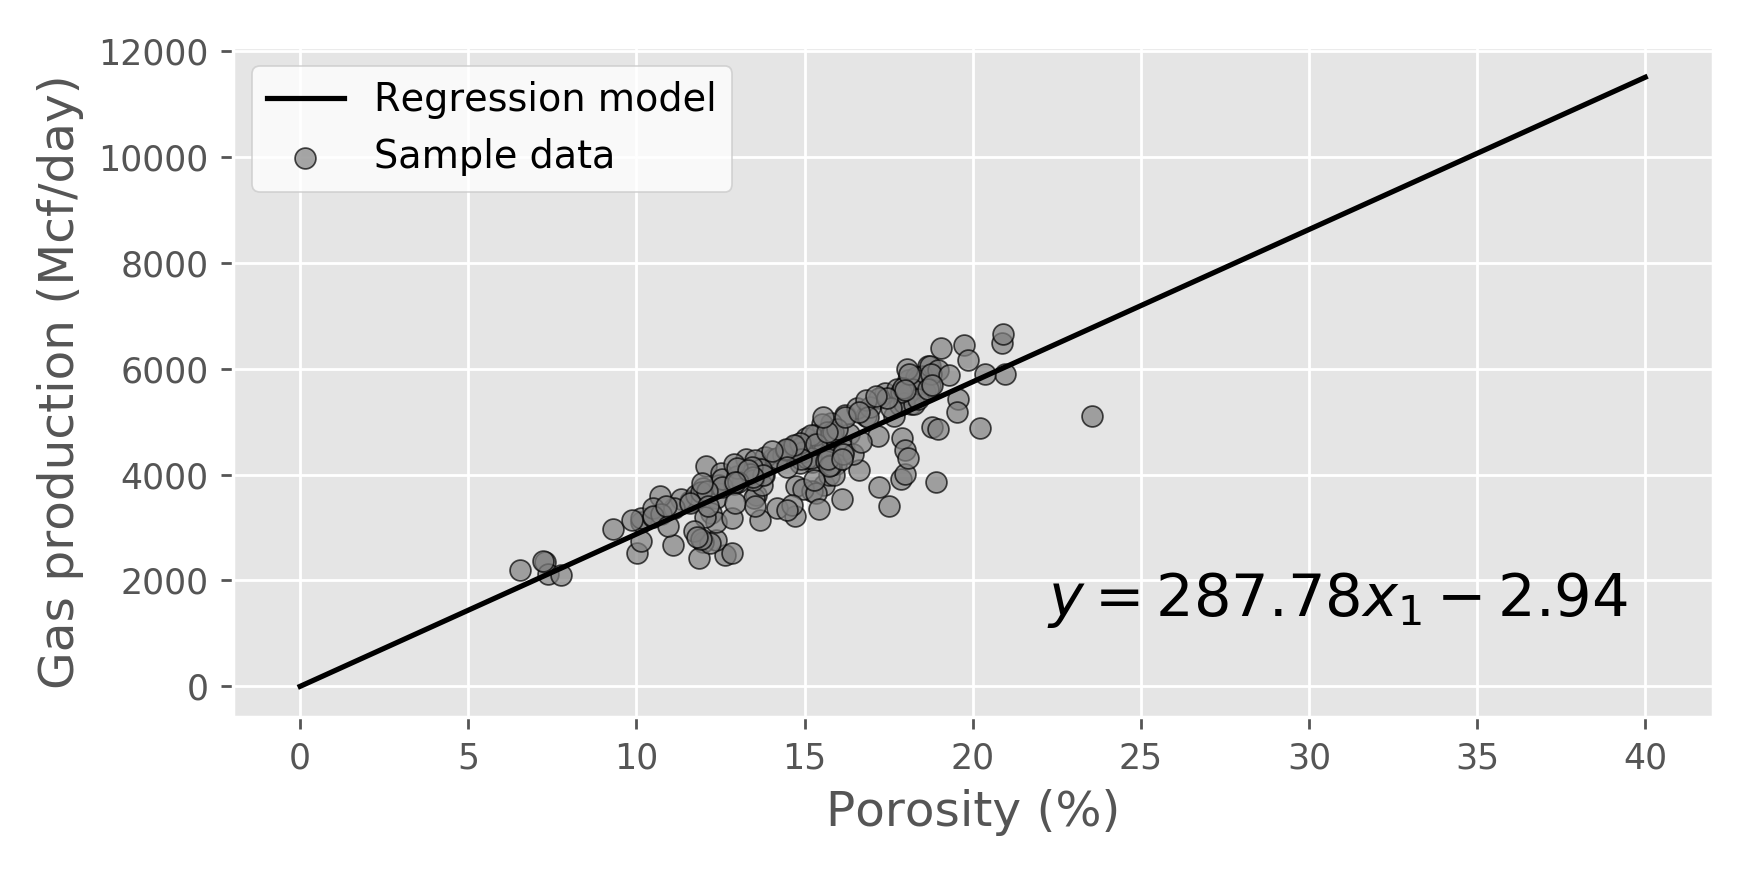

In [52]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(7, 3.5))

ax.plot(x_pred, y_pred, color='k', label='Regression model')
ax.scatter(X, y, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
ax.set_ylabel('Gas production (Mcf/day)', fontsize=14)
ax.set_xlabel('Porosity (%)', fontsize=14)
ax.legend(facecolor='white', fontsize=11)
ax.text(0.55, 0.15, '$y = %.2f x_1 - %.2f $' % (model.coef_[0], abs(model.intercept_)), fontsize=17, transform=ax.transAxes)

fig.tight_layout()

<div><hr></div>

<div id="Forcing zero y-intercept"></div>
<p style="color: #666"><b>Pythonic Tip:</b> Forcing zero y-intercept<p>
    
Sometimes you want to force y-intercept = 0. This can be done by setting <code>fit_intercept=False</code> when instantiating the linear regression model class. Printing the model y-intercept will output <code>0.0</code>.

<div style="margin-bottom: -20px"></div>

In [53]:
ols = linear_model.LinearRegression(fit_intercept=False)
model = ols.fit(X, y)

In [54]:
model.intercept_

0.0

<div style="margin-top: -20px"></div>

In <a href="#fig-7">figure (7)</a>I generated some synthetic data below to illustrate the effect of forcing zero y-intercept. Forcing a zero y-intercept can be both desirable or undesirable. If you have a reason to believe that y-intercept must be zero, use the above code snippet to suit your need. 

<div id="fig-7" class="row" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multiple_linear_zero_intercept.png"></div>
    <div class="col-12"><p class="image-description">Figure 7: Effect of forcing zero y-intercept</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (7)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import pandas as pd
                import numpy as np
                import matplotlib.pyplot as plt
                from sklearn import linear_model

                df = pd.read_csv('https://aegis4048.github.io/downloads/notebooks/sample_data/linear_data.csv')

                features = ['X']
                target = 'Y'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                x_pred = np.linspace(0, 40, 200).reshape(-1, len(features)) # prediction line

                ##################################### Fit linear model ####################################

                ols_1 = linear_model.LinearRegression()
                model_1 = ols_1.fit(X, y)
                response_1 = model_1.predict(x_pred)

                ################################# Force zero y-intercept ##################################

                ols_2 = linear_model.LinearRegression(fit_intercept=False)
                model_2 = ols_2.fit(X, y)
                response_2 = model_2.predict(x_pred)

                ########################################## Plot ###########################################

                plt.style.use('default')
                plt.style.use('ggplot')

                fig, axes = plt.subplots(1, 2, figsize=(10, 4))
                fig.suptitle('Effect of enforcing zero y-intercept', fontsize=15)

                axes[0].plot(x_pred, response_1, color='k', label='Regression model')
                axes[0].scatter(X, y, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
                axes[0].set_ylabel('Y', fontsize=14)
                axes[0].set_xlabel('X', fontsize=14)
                axes[0].legend(facecolor='white', fontsize=11, loc='best')
                axes[0].set_ylim(0, 1600)
                axes[0].set_xlim(0, 0.05)
                axes[0].text(0.47, 0.15, '$y = %.1f x_1 + %.1f $' % (model_1.coef_[0], model_1.intercept_), 
                             fontsize=12, transform=axes[0].transAxes)
                axes[0].text(0.77, 0.3, 'aegis4048.github.io', fontsize=10, ha='center', va='center',
                         transform=axes[0].transAxes, color='grey', alpha=0.5)

                axes[1].plot(x_pred, response_2, color='k', label='Regression model')
                axes[1].scatter(X, y, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
                axes[1].set_ylabel('Y', fontsize=14)
                axes[1].set_xlabel('X', fontsize=14)
                axes[1].legend(facecolor='white', fontsize=11, loc='best')
                axes[1].set_ylim(0, 1600)
                axes[1].set_xlim(0, 0.05)
                axes[1].text(0.55, 0.15, '$y = %.1f x_1 + %.1f $' % (model_2.coef_[0], model_2.intercept_), 
                             fontsize=12, transform=axes[1].transAxes)
                axes[1].text(0.77, 0.3, 'aegis4048.github.io', fontsize=10, ha='center', va='center',
                         transform=axes[1].transAxes, color='grey', alpha=0.5)

                fig.tight_layout(rect=[0, 0, 1, 0.94])
            </code>
        </pre>
    </div>
</div>

<div><hr></div>

<div id="3D+ linear regression with scikit-learn"></div>
<p style="color: #666"><b>Pythonic Tip:</b> 3D+ linear regression with scikit-learn<p>
    
<p><b>Fit multi-linear model</b></p>
<p></p>
    
Let's fit the model with four features: <i>Por</i>, <i>Brittle</i>, <i>Perm</i>, and <i>TOC</i>. Then the model of our interest has the following structure:

<div id="eq-5" style="font-size: 1rem;">
$$ \text{Gas Prod.} = \beta_1 \cdot \text{Por} + \beta_2 \cdot \text{Brittle} + \beta_3 \cdot \text{Perm} + \beta_4 \cdot \text{TOC} + \beta_0 \tag{5}$$
</div>

With scikit-learn, fitting 3D+ linear regression is no different from 2D linear regression, other than declaring multiple features in the beginning. The rest is exactly the same. We will declare four features: <code>features = ['Por', 'Brittle', 'Perm', 'TOC'].</code>

<div style="margin-bottom: -20px"></div>

In [16]:
import pandas as pd
import numpy as np
from sklearn import linear_model

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

features = ['Por', 'Brittle', 'Perm', 'TOC']
target = 'Prod'

X = df[features].values.reshape(-1, len(features))
y = df[target].values

ols = linear_model.LinearRegression()
model = ols.fit(X, y)

In [17]:
model.coef_

array([244.60011793,  31.58801063,  86.87367291, 325.19354135])

In [15]:
model.intercept_

-1616.4561900851832

<div style="margin-top: -20px"></div>

Based on the result of the fit, we obtain the following linear regression model:

<div id="eq-6" style="font-size: 1rem;">
$$ \text{Gas Prod.} = 244.6 \cdot \text{Por} + 31.6 \cdot \text{Brittle} + 86.9 \cdot \text{Perm} + 325.2 \cdot \text{TOC} - 1616.5 \tag{6}$$
</div>

<div id="multi-Accuracy assessment"></div>

**Accuracy assessment: $R^2$**

In the same we evaluated model performance with 2D linear model <a href="#Accuracy assessment">above</a>, we can evaluate the 3D+ model performance with R-squared with <code>model.score(X, y)</code>. <code>X</code> is the features, and <code>y</code> is the response variable used to fit the model. 

In [106]:
model.score(X, y)

0.9452003827311295

<div id="multi Make future prediction"></div>

**Make future prediction**

Let's make one prediction of gas production rate when:

<div><hr></div>

1. Por = 12 (%)
2. Brittle = 81 (%)
3. VR = 2.31 (%)
4. AI = 2.8 (kg/m2s*10^6)

<div style="margin-bottom: -20px"></div>

In [107]:
x_pred = np.array([12, 81, 2.31, 2.8])
x_pred = x_pred.reshape(-1, len(features))

In [108]:
model.predict(x_pred)

array([4555.02177976])

<div style="margin-top: -10px"></div>

This time, let's make two predictions of gas production rate when:

<div><hr></div>

1. Por = 12 (%)
2. Brittle = 81 (%)
3. VR = 2.31 (%)
4. AI = 2.8 (kg/m2s*10^6)

<div><hr></div>

1. Por = 15 (%)
2. Brittle = 60 (%)
3. VR = 2.5 (%)
4. AI = 1 (kg/m2s*10^6)

<div style="margin-bottom: -20px"></div>

In [109]:
x_pred = np.array([[12, 81, 2.31, 2.8], [15, 60, 2.5, 1]])
x_pred = x_pred.reshape(-1, len(features))

In [100]:
model.predict(x_pred)

array([4555.02177976, 5312.03205244])

<div id="Introduction to multicollinearity"></div>

## 2. Introduction to multicollinearity

While an accuracy of a multi-linear model in predicting a response variable may be reliable, the value of individual regression coefficient may not be reliable under multicollinearity. Note that the value of regression coefficient for porosity in <a href="#eq-4">eq (4)</a> is 287.7, while it is 244.6 in <a href="#eq-6">eq (6)</a>. In <a href="#fig-8">figure (8)</a>, I simulated multiple model fits with different combinations of features to show the fluctuating regression coefficient values, even when the R-squared value is high. 

<div id="fig-8" class="row full_screen_margin_md mobile_responsive_plot_full_width" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multiple_linear_model_instability.png"></div>
    <div class="col-12"><p class="image-description">Figure 8: Unstable regression coefficients due to multicollinearity</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (8)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import pandas as pd
                import numpy as np
                from sklearn import linear_model
                import matplotlib.pyplot as plt

                file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
                df = pd.read_csv(file)

                ########################################################################################

                features = ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'Perm', 'TOC', 'VR']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'Perm', 'TOC', 'AI']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'Perm', 'TOC']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'Perm', 'AI']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'Perm', 'VR']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'TOC', 'VR']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'TOC']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'VR']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'AI']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
            </code>
        </pre>
    </div>
</div>

The simulation result tells us that even if the model is good at predicting the response variable given features (high R-squared), linear model is not robust enough to fully understand the effect of individual features on the response variable. In such circumstance, we can't trust the values of regression coefficients. Where is this instability coming from? This is because the *Por*, *TOC*, and *Perm* shows strong linear correlation with one another, as shown in the below spearnman's correlation matrix in <a href="#fig-9">figure (9)</a>.

<div id="fig-9" class="row full_screen_margin_md mobile_responsive_plot_full_width" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/mutliple_linear_correlation_matrix.png"></div>
    <div class="col-12"><p class="image-description">Figure 9: Correlation matrix of features</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (9)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import numpy as np
                import pandas as pd
                import seaborn as sns
                import matplotlib.pyplot as plt

                file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
                df = pd.read_csv(file)

                df = df.iloc[:, 1:-1]

                corr = df.corr(method='spearman')

                # Generate a mask for the upper triangle
                mask = np.zeros_like(corr, dtype=np.bool)
                mask[np.triu_indices_from(mask)] = True

                # Set up the matplotlib figure
                fig, ax = plt.subplots(figsize=(6, 5))

                # Generate a custom diverging colormap
                cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)

                # Draw the heatmap with the mask and correct aspect ratio
                sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)

                fig.suptitle('Correlation matrix of features', fontsize=15)
                ax.text(0.77, 0.2, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
                         transform=ax.transAxes, color='grey', alpha=0.5)

                fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

When more than two features are used for prediction, you must consider the possibility of each features interacting with one another. For thought experiment, think of two features $x_1$ and $x_2$, and a response variable $y$. Assume that $x_1$ is positively related to $y$. In the other words, increasing $x_1$ increases $y$, and decreasing $x_1$ also decreases $y$. $x_2$ is negatively related to $y$. There is a positive correlation between $x_1$ and $x_2$. Under this sitution, when you increase $x_1$, you expect to increase the value of $y$ because of the positive relationship between $x_1$ and $y$, but this is not always true because increasing $x_1$ also increases $x_2$, which in turn decreases $y$ . 

> The situation in which features are correlated with one another is called **muticollinearity**. Under multicollinearity, the values of individual regression coefficients are unreliable, and the impact of individual features on a response variable is obfuscated. However, prediction on a response variable is still reliable.

When using linear regression coefficients to make business decisions, you must remove the effect of multicollinearity to obtain reliable regression coefficients. Let's say that you are doing a medical research on cervical cancer. You trained a linear regression model with patients' survival rate with respect to many features, in which water consumption being one of them. Your linear regression coefficient for water consumption reports that if a patient increases water consumption by 1.5 L everyday, his survival rate will increase by 2%. Can you trust this analysis? The answer is yes, if there is no sign of multicollinearity. You can actually tell the patient, with confidence, that he must drink more water to increase his chance of survival. However, if there is a sign of multicollinearity, this analysis is not valid. 

Note that multicollinearity is not restricted on 1 vs 1 relationship. Even if there is minimum 1 vs 1 correlation among features, three or more features together may show multicollinearity. Also note that **multicollinearity does not affect prediction accuracy**. While the values of individual coefficients may be unreliable, it does not undermine the prediction power of the model. Multicollinearity is an issue only when you want to study the impact of individual features on a response variable.

The details of detection & remedies of mutlicollinearity is not discussed here (though I plan to write about it very soon). While the focus of this post is only on multiple linear regression itself, I still wanted to turn grab your attention as to why you should not always trust your regression coefficients.